In [101]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torch.utils.model_zoo as model_zoo
from torchvision import transforms
from tqdm.notebook import tqdm
import logging as log
import IProgress


In [102]:
pcam_directory = '/Users/costanzasiniscalchi/Documents/Senior/ACV/project/histopathologic-cancer-detection'

In [103]:
label_mapping = {}
with open(os.path.join(pcam_directory, 'train_labels.csv'), 'r') as f:
    reader = csv.reader(f)
    next(reader)  # To skip the header
    label_mapping = {slide_id: int(label) for [slide_id, label] in reader}

In [104]:
freq = {}
for _, label in label_mapping.items():
    if label not in freq:
        freq[label] = 0.
    freq[label] += 1.
freq = {k: v / len(label_mapping) for (k, v) in freq.items()}
freq, len(label_mapping)

({0: 0.5949687535507329, 1: 0.40503124644926713}, 220025)

In [105]:
all_fps = [fp for fp in os.listdir(os.path.join(pcam_directory, 'train'))]
for fp in all_fps: assert fp[-4:] == '.tif', fp[-4:]

In [106]:
permutation = np.random.permutation(range(len(all_fps)))
train_fps, val_fps = (
    [
        (os.path.join(pcam_directory, 'train', all_fps[index]), label_mapping[all_fps[index][:-4]])
        for index in permutation[:int(len(permutation) * .8)]
    ],
    [
        (os.path.join(pcam_directory, 'train', all_fps[index]), label_mapping[all_fps[index][:-4]])
        for index in permutation[int(len(permutation) * .8):]
    ]
)

In [107]:
len(train_fps), len(val_fps)

(176020, 44005)

Size of image (96, 96)


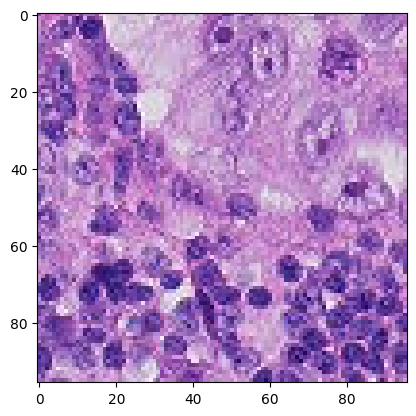

In [108]:
example_image_fp, example_label = train_fps[0]
example_image = Image.open(example_image_fp)
print("Size of image", example_image.size)
plt.imshow(example_image)

In [109]:
sizes = {}
for fp, _ in tqdm(train_fps):
    sizes[Image.open(fp).size] = 1
for fp, _ in tqdm(val_fps):
    sizes[Image.open(fp).size] = 1


  0%|          | 0/176020 [00:00<?, ?it/s]

  0%|          | 0/44005 [00:00<?, ?it/s]

In [110]:
class PCamDataset(torch.utils.data.Dataset):
    def __init__(self, examples, transform=None):
        self.examples = examples
        self.transform = transform

    def __getitem__(self, index):
        image_fp, label = self.examples[index]
        image = Image.open(image_fp)
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.Tensor([label]).long()

    def __len__(self):
        return len(self.examples)

In [111]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet statistics
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet statistics
])


In [112]:
tr_ds, val_ds = PCamDataset(train_fps, transform=train_transforms), PCamDataset(val_fps, transform=val_transforms)
tr_dl, val_dl = (
    torch.utils.data.DataLoader(tr_ds, batch_size=32, shuffle=True),
    torch.utils.data.DataLoader(val_ds, batch_size=32)
)

In [113]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """Return a 3x3 convolution taking in `in_planes` filters and outputting
       `out_planes` filters with padding and stride `stride`."""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride,
        padding=1, bias=False
    )


def conv1x1(in_planes, out_planes, stride=1):
    """Return a 1x1 convolution taking in `in_planes` filters and outputting
       `out_planes` filters with padding and stride `stride`."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [114]:
class BasicBlock(nn.Module):
    """The basic building block for ResNets, encompassing the residual connection. Takes in
       `inplanes` number of input filters, outputs `planes` number of output filters, with
       stride `stride` on the first 3x3 conv, and an optional downsampling (`nn.Module`)
       on the residual output via the `downsample` parameter."""
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """The bottleneck building block for ResNets, encompassing the residual connection. Takes in
       `inplanes` number of input filters, outputs `planes` number of output filters, with
       stride `stride` on the first 3x3 conv, and an optional downsampling (`nn.Module`)
       on the residual output via the `downsample` parameter."""
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [115]:
#collapse_hide
class ResNet(nn.Module):
    """Constructs a ResNet using a block specification and number of layers. Also specifies where to
       output training logs and model/system state."""
    def __init__(
        self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.out_fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.out_fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model."""
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']), strict=False)
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model."""
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']), strict=False)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model."""
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']), strict=False)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model."""
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']), strict=False)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model."""
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']), strict=False)
    return model

In [116]:
model = resnet18(pretrained=True, num_classes=2)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.AdamW([{'params': model.out_fc.parameters(), 'lr': 1e-3}])
criterion = nn.CrossEntropyLoss()
num_epochs = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-2,
    total_steps=num_epochs * len(tr_dl),
)

In [117]:
def train(model, epoch, dataloader, criterion, optimizer, scheduler=None):
    model.train()
    total, total_loss, total_correct = 0, 0., 0.

    tqdm_iterator = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (x, y) in tqdm_iterator:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        output = model(x)
        prediction = torch.argmax(output, -1)
        loss = criterion(output, y.squeeze())
        total_loss += loss.item() * len(y)
        total_correct += (prediction == y.squeeze()).sum().item()
        total += len(y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        tqdm_iterator.set_postfix({
            "Loss": (total_loss / total), "Accuracy": (total_correct / total)
        })
    final_loss, final_acc = total_loss / total, total_correct / total
    log.info(
        "Reporting %.5f training loss, %.5f training accuracy for epoch %d." %
        (final_loss, final_acc, epoch)
    )
    return final_loss, final_acc

In [118]:
for i in range(num_epochs):
    train(model, i + 1, tr_dl, criterion, optimizer, scheduler)

  0%|          | 0/5501 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
base_lr = 1e-3
lower_bound_factor = 1e-5
upper_bound_factor = 1e-2
body_parameters = [
    (param, _) for (param, _) in model.named_parameters() if param.split('.')[0] != 'out_fc'
]
lrs = np.geomspace(
    base_lr * lower_bound_factor, base_lr * upper_bound_factor,
    len(body_parameters)
)
param_lr_maps = [
    {'params': param, 'lr': lr} for ((_, param), lr) in
    zip(body_parameters, lrs)
]
param_lr_maps.append({'params': model.out_fc.parameters(), 'lr': base_lr})


In [ ]:
optimizer = torch.optim.AdamW(param_lr_maps, lr=base_lr)
criterion = nn.CrossEntropyLoss()
num_epochs = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=base_lr,
    total_steps=num_epochs * len(tr_dl),
)


In [ ]:
for i in range(num_epochs):
    train(model, i + 1, tr_dl, criterion, optimizer, scheduler)